[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/10_nb_interpretale_ML.ipynb) 

# BADS - Interpretable Machine Learning

So far, we have talked about data analysis, data preprocessing, feature engineering, as well as model estimation and evaluation. In this week's BADS tutorial, we want to discuss how we can interpret our analytical models. Currently, many potent models are also very complex, and thus their decisions can be hard to follow for humans. This is also referred to as the interpretability vs. accuracy trade-off. Why does interpretability matter at all? When we decide whether or not someone will get a discount, making a wrong prediction can come with a reasonably low cost. However, when we talk about medicine or banks giving out credits, the cost of classifying someone wrong becomes much higher. Predictive accuracy, the perspective we used to focus on when judging model quality, remains useful but is typically regarded as insufficient. To build trust in a model, we need to demonstrate that the model recommendations (e.g., predictions) are consistent with domain knowledge. Being able to explain the model-estimated feature-to-target relationship in an easy to understand way is the most important step. Even for predictive accuracy, understanding the feature-target relationship, which will determine predictions, is useful if not crucial. To see this, recall that we evaluate predictive accuracy on a test set, which is only a sample from the population. Say we have a model that predicts the test data highly accurately. Are we comfortable with believing that future data beyond the test set (sample) will be predicted with the same high degree of accuracy? Maybe, but typically we would want additional evidence. Knowing the way in which a model translates feature values into predictions and knowing that this translation is sensible brings the additional amount of comfort. Let's stress this point with a counterexample. Say you build a model to predict health risks. You would not trust a model that predicts health conditions to improve with excessive consumption of alcohol, smoking, deprivation of sleep, junk food, etc. We know these factors (i.e., feature values) are unhealthy and a model predicting, e.g., life expectation in years, must reflect this domain knowledge in its forecasts. Else, no matter what test set accuracy might reveal, we would reject for the model for not being plausible. This shows why knowing the feature-to-target relationship is so important. Beyond building trust, regulations might demand insight into models, for example in financial context, and thus rule out black-box models. In this chapter, we will look into different techniques that promise to explain the decisions of black-box models and make the feature-to-target relationship interpretable. Note the the topic, which goes by the name **interpretable machine learning (IML)** or, synonymously, **explainable AI (xAI)**, is very prominent at the moment and attracts much in academia and the industry. If interested, the survey paper of [Arrieta et al. (2019)](https://arxiv.org/abs/1910.10045) offers a nice overview of some recent research; or have a look at the [high-caliber Nature paper of Lundberg et al. (2020)](https://doi.org/10.1038/s42256-019-0138-9). 

The outline of this tutorial is as follows:
- Preliminaries
- Global feature importance analysis
- Local interpretability
  - The LIME approach
  - SHAP-based explanations

# Preliminaries
As always, we start with importing some standard packages and loading our (credit) data. Further, we need some black-box models the predictions of which we aim at interpreting. The corresponding codes are well-known by now, so no need for further explanation. However, before continuing with loading libraries and building models, this tutorial requires a bit of housekeeping. We use new libraries that will typically not be available in your Python environment. Therefore, the following section elaborates on the installation of libraries on-the-fly. 


## Installing Python packages on the fly
Later in the tutorial, we will make use of some Python libraries that provide xAI functionality and are not part of the anaconda distribution. Likewise, those packages are not available when you start Google Colab. Therefore, you will have to install those libraries when you first run this notebook. If you have installed Python on your machine and run the notebook there, please install the following two packages before moving on:
- Shap (https://pypi.org/project/shap/)
- LIME (https://pypi.org/project/lime/)

However, we guess that most of you have used the Anaconda distribution. At the time of writing, the Anaconda distribution does not feature versions of the above packages so that you have to install them using the package manager *pip*. Here is a [nice blog](https://www.anaconda.com/blog/understanding-conda-and-pip) explaining the differences between conda and pip if your are interested. Our own testing did not suggest that using pip in a conda environment causes problems. However, it is a known fact that mixed use of pip and conda might create issues (see, e.g., [here](https://www.anaconda.com/blog/using-pip-in-a-conda-environment)) and should, therefore, be avoided whenever possible. Well avoidance is not an option for us because we want to use the above packages, which are only available on [PyPi](https://pypi.org/).

Furthermore, the notebook includes one example that requires the newest stable version of sklearn. Most likely, you will not have installed this version on your local computer. You could consider updating sklearn but this bears the risk that other packages (e.g., Pandas) might not be fully compatible. Long story short, **we strongly recommend that you use Google Colab for this notebook.** Anytime you launch Colab, you start from a fresh Python environment. You can update this environment as you need it. When something goes wrong (e.g., you observe incompability between two packages) you can simply start from scratch. In theory, Conda supports a similar workflow. For example, you can (and should!) clone your Conda environment before making changes by installating new packages. To sum up, we recommend that you only update your local machine to run this notebook if you really know what you are doing. Else, better use Colab.

Assuming that you have followed our advise and now find yourself running the notebook in Colab, you can easily install any package that you need on-the-fly by putting the command ` !pip install ` or `!apt-get install` into a code cell. The commands have to be followed by the name of the package your want to install. After installation, the package can be imported as usual. 

Some useful codes for installing packages in Google Colab:

```
# To install a package 
!pip install lime

# To find out what version is installed:
!pip show lime

# To update the package to the most recent version: 
!pip install --upgrade lime

# To install a specific version:
!pip install lime==2.1.2
```
We will install these packages now and then import them later in this notebook, when we first use them.


In [ ]:
# THIS CODE WILL UPDATE SKLEARN TO THE LATEST STABLE VERSION

# ONLY RUN THIS CODE ON YOUR LOCAL COMPUTER IF YOU FULLY UNDERSTAND THE IMPLICATIONS

# OTHERWISE USE GOOGLE COLAB
!pip install --upgrade scikit-learn

In [ ]:
# Install LIME and SHAP package 

# YOU ONLY NEED TO RUN THE FOLLOWING COMMANDS ONCE WHEN USING YOUR OWN COMPUTER

# YOU NEED TO RUN THE FOLLOWING COMMANDS EVERY TIME WHEN USING GOOGLE COLAB 

# To install the packages simply uncomment the following two lines of code

!pip install lime
!pip install shap

## Loading libraries and training classifiers

In [6]:
# Import standard packages. 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data for this tutorial directly from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv'

print('Fetching data...')
df = pd.read_csv(data_url, index_col='index')
df['DEROGzero'] = df['DEROGzero'].astype('int64')

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']].values
X_var_labels = df.columns[1:df.shape[1]]

# Data partitioning
from sklearn.model_selection import train_test_split

# Select random state to make results reproducable
rnd_state = 888 

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = rnd_state)  # 30% of the data as hold-out

# Make yourself familiar with these vectors
print('Shape of the data ', y_train.shape, X_train.shape, y_test.shape, X_test.shape)

Fetching data...
Shape of the data  (4172, 1) (4172, 18) (1788, 1) (1788, 18)


The next codes train our two models, which may take a little time so please be patient.

In [7]:
# Train XGB model
print('Training XGB and RF classifier...')
from xgboost import XGBClassifier

xgb = XGBClassifier(
    max_depth=10, n_estimators=100,  eval_metric="logloss", learning_rate = 0.1, colsample_bytree = 0.7, use_label_encoder=False, random_state= rnd_state)
xgb.fit(X_train, y_train.ravel())

# Train Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=15, random_state = rnd_state) 
rf.fit(X_train, y_train.ravel())

# Evaluate models
from sklearn.metrics import roc_auc_score
print('XGB AUC is: {:.4}'.format(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])))
print('RF AUC is: {:.4}'.format(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])))

Training XGB and RF classifier...
XGB AUC is: 0.9575
RF AUC is: 0.9497


Apparently, our two black-box models predict highly accurately. We are almost ready to start our journey into the realms of xAI. Prior to that, however, we need to briefly discuss a little bit of infrastructure. 

# Global feature importance analysis
Given the interest in xAI, it is not surprising that `sklearn` already provides some nice functionality for explaining model predictions. Being part of the `sklearn` environment, these functions are particularly easy to use and it makes sense to start the tutorial with them. As the title of the section suggests, `sklearn` functionality supports global explanations. 

## Impurity-based feature importance for tree-based models
Plots showing the relative importance of a feature for a model have been around long before acronyms like IML or xAI were invented. The seminal papers of Breiman and Friedman on bagging, random forest, and gradient boosting already included such plots. The corresponding functionality is still available in many packages that implement tree-based algorithms. The specific way in which tree-based algorithms use features makes computing importance statistics very easy. Imagine a tree-growing algorithm - or go back to [Tutorial #5](https://github.com/Humboldt-WI/bads/blob/master/tutorials/5_nb_supervised_learning.ipynb) - and assume a node is split using a feature *age*. This split on *age* will be associated with a decrease in impurity, measured in terms of, e.g., the GINI coefficient, entropy, etc. We can easily add up the amount of impurity reduction due to splits on the feature *age*. We can as easily weight each split or rather impurity reduction by the number of observations affected by the split. This ensures that splits higher-up in the tree receive more weight. This approach provides with a measure capturing the total contribution of the feature *age* toward impurity reduction in the tree. Repeating the process for every feature in the data set, we can compare how valuable each feature has been. This approach, which is known as [impurity-based importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_), naturally extends to tree-based ensemble learners. The following examples demonstrate how to compute impurity-based importance for our RF and XGB classifiers. 

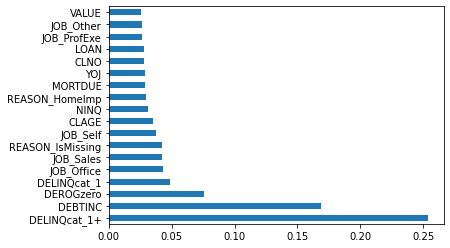

In [8]:
# Feature importance XGBoost
feat_importances_xgb = pd.Series(xgb.feature_importances_, index= X_var_labels)
feat_importances_xgb.nlargest(20).plot(kind='barh');

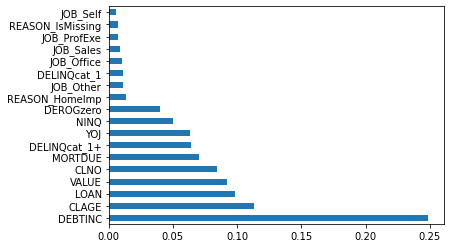

In [9]:
# Feature importance RF
feat_importances_rf = pd.Series(rf.feature_importances_, index= X_var_labels)
feat_importances_rf.nlargest(20).plot(kind='barh');

**How to read this plot:** <br>
The plot depicts:
- the features on the y-axis
- their importance on the x-axis

For example, the feature DEBTINC is of great importance for both models, with a value of over 0.15 for the XGB model, and almost 0.25 for the RF model. As said above, these values, e.g., 0.25 represent the total amount of impurity-reduction due to a feature relative to others features. That is, the importance scores have been normalized to sum to one. However, we also note notable differences between the RF and XGB results. The latter considers DELINQcat as most important feature whereas RF uses that feature to a far lesser extent.

In [10]:
np.sum(rf.feature_importances_)

1.0

**When to use this plot:** <br>
This plot is handy to improve the process of building our model. As you know, the more features we include in a model, the more likely it is to overfit. This plot shows us how many features contributed to the outcome of our predictions. This can help us identify which features we should keep in our model and which we might be able to leave out. For example, we observe for the RF classifier that dummy variables encoding the occupation of the applicant (JOB_xxx) are rarely used for splitting a tree-node and thus contribute little information. The same goes for the feature REASON. We would probably not lose accuracy if we discard those features. Does the unimportance of JOB and REASON agrees with domain knowledge? Answering this question might be hard for us as we do not work for the bank that supplied that data but it is easy to accept that a credit analyst of that bank would know. In summary, the plot helps the data scientist to select features and the analyst to judge whether the model complies with domain knowledge, at least to some extent. For example, it makes a lot of sense that the debt to income ratio (DEBTINC) is highly relevant to predict default. Speaking about the data scientist's perspective, you might notice that all the unimportant features are categories so an alternative interpretation of the plot is that we might have messed up our preparation of the categorical variables. A good opportunity for trying out WOE :) 

**Caveats:**<br>
You can think of the above plot as an analog of inspecting regression coefficients in a linear model. A linear model is considered interpretable because the regression coefficients tell you how the model translates feature values into predictions. You get some insight on that matter from the above plot. However, a very importance piece of information is missing. In which direction does a feature affect predictions? Speaking about credit risk, is a higher or a lower depth-to-income ratio better? Of course, we have a clear opinion but we cannot verify that the model got the relationship right. Knowing the direction of a feature effect - say the sign of a regression coefficient - is crucial to build trust in a model and confirm the estimated feature-to-target relationship to agree with domain knowledge and/or prior believes. Hence, we need more diagnostic tools to complement the analysis. More on that later.

It turns out that there is another problem. Not so much with the plot but the way impurity-based importance is computed. [Strobl et al. (2007)](http://dx.doi.org/10.1186/1471-2105-8-25) demonstrate how the impurity-based approach is biased toward categorical variables with many levels. Our data does not include many categories and the two categories we have distinguish only a few levels. Thus, we are probably ok with using impurity-based importance. In general, however, you should use **permutation-based** importance. It will produce the same output and thus support the same use cases. The computation of the impor and suffer from s In essence, you should not use it  Seminal work of 

## Permutation-based feature importance
Permutation-based feature importance is a learner-agnostic way to judge the relevance of features. It produces an ordinal feature ranking. In order to do this, we permute one feature by shuffling its values across all observations. This means each observation will receive a new value. This permutation breaks the relationship to the target variable. In other words, a learner should no longer be able to use the information in the feature to predict the target. Permutation-based feature importance exploits this by comparing the predictive performance of a model before and after permuting a feature. The higher the increase of the prediction error due to the permutation, the more important the feature. Repeating the comparison of before vs. after permutation model performance for all features, we can again obtain a ranking of features. Let's see how this works for the XGB classifier.

In [12]:
plt.rcParams['figure.figsize'] = 20, 10

# Permutation-based feature importance
print('Computing permutation-based feature importance...')
from sklearn.inspection import permutation_importance

classifier = xgb

perm_imp = permutation_importance(classifier, X_test, y_test, scoring='roc_auc', n_repeats=5, random_state=123)
sorted_idx = perm_imp.importances_mean.argsort()

Computing permutation-based feature importance...


Here is some standard code from the web to create a nice plot based on the results, which mimics the above bar plots. However, the code exploits the fact that the function `permutation_importance` repeats the calculation by default. We highlight this behavior in the above call by explicitly incorporating the parameter `n_repeats`. Repetition implies that we have multiple (i.e., five) importance scores per feature. Therefore, we can use a box-plot to show the results. We could alternatively average over the multiple importance scores and depict results in a bar plot. We showcase that approach later in the notebook (see the last bits on partial-dependence analysis).

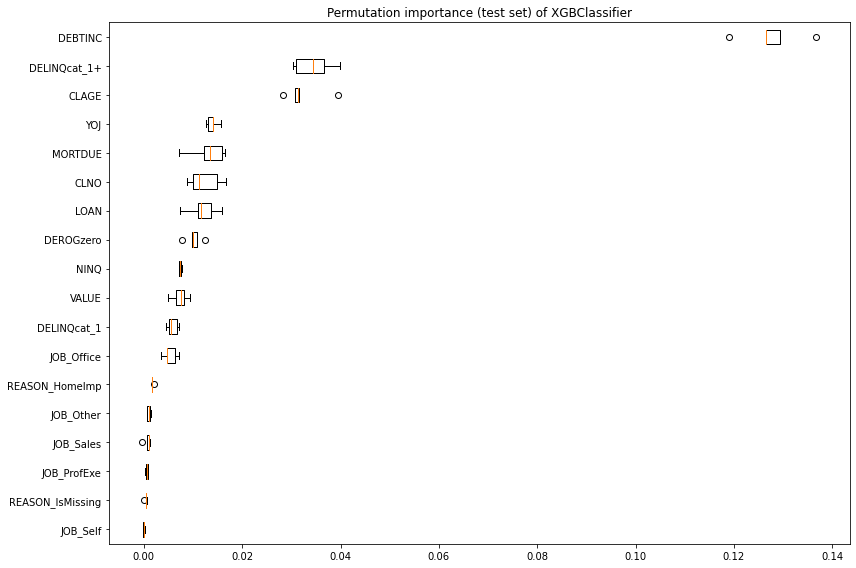

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_var_labels[sorted_idx])
ax.set_title("Permutation importance (test set) of {}".format(str(classifier)[0:str(classifier).find('(')]))
fig.tight_layout()
plt.show()

Given the above discussion of the results of impurity-based importance, the use of the previous plot is obvious. The box-plots clearly add additional insight on the robustness of feature importance scores and, more importantly, permutation-based feature importance overcomes the problems - you could say flaws - of impurity-based importance associated with high-cardinal categorical features as discussed above. In summary, to get insight into the global importance of features you want to use permutation-based importance. This is possible with any type of learning algorithm, including but not limited to tree-based classifiers. Different modeling problems such as regression and classification are also supported because the approach is based on a decrease of predictive performance and, therefore, generic. 

To better understand the values of the feature importance scores, you can check out the [`sklearn` documentation where the calculation is detailed](https://scikit-learn.org/stable/modules/permutation_importance.html).  

## Partial dependence analysis
A partial dependence plot (PDP) depicts the **marginal** effect of a feature on model predictions, and this complements permutation-based feature importance analysis. Remember that the latter is useful to understand on which features a model relies. Afterwards, however, we still do not know whether higher/lower values of a feature lead to higher/lower predictions. For example, does the model-estimated default probability increases of decreases when the dept-to-income ratio increases? A PDP answers this question and is, therefore, a natural complement to permutation-based feature importance. A PDP plots the values of a focal feature (on the x-axis) against model predictions (on the y-axis) whilst accounting for the combined effect of all other features (hence marginal effect).As discussed in the lecture, this marginalization is basically achieved by examining the model prediction for each value of the focal variable while averaging over the values for other variables. We refer to the lecture on interpretable machine learning for a more formal coverage of partial-dependence analysis. Here, we proceed with a demo and examine the partial dependency between the model-estimated probability of default and the feature CLAGE (the age of the oldest credit line in month).

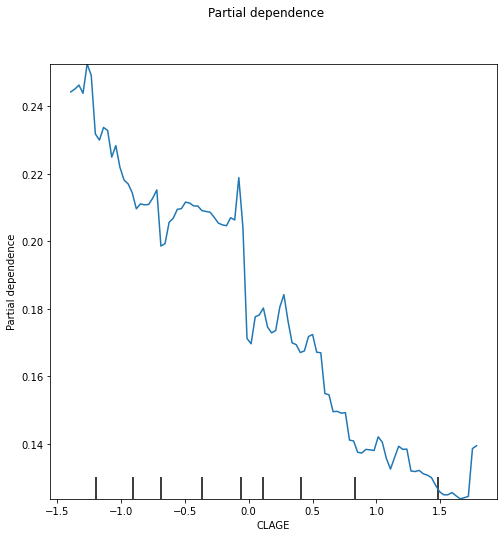

In [14]:
# Partial dependence of CLAGE
plt.rcParams['figure.figsize'] = 8,8
from sklearn.inspection import plot_partial_dependence
classifier = xgb  # change this to rf if you wish to examine the dependency of the RF classifier
plot_partial_dependence(classifier, X_train, features=['CLAGE'], feature_names=X_var_labels)
fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

**How to read this plot:** <br>
This plot depicts:
- the  selected feature on the x-axis
- the partial dependence/ effect of the selected feature on the outcome
- the deciles of distribution of the focal feature (bars on the x-axis)

Based on the previous plot, larger values of the feature CLAGE decreases the risk of default. What does *larger values* of CLAGE imply? Remember, the feature captures the length of the oldest credit line in month. We do not want to go into the details of how this feature is defined. In practice, this is exactly what you should do to ensure correct interpretation of the plot. In this tutorial, however, we can simplify things a bit and assume that the feature CLAGE captures how long we know and do business with the customer. Out of all the credit products the customer might have, one will be the oldest and we measure how long the credit for this product is already running. Intuitively, somebody who is paying back their credit for a long time appears to be a *good* borrower. After all, s/he has apparently not defaulted on that oldest credit line. With this understanding of the feature, the shape of the PDP makes sense. Our model (i.e., XGB) predicts lower default probability when seeing a feature value of CLAGE that is relatively large. This is the kind of insight you want to obtain from a PDP. It is also the type of insight that complements the permutation-based feature importance analysis. PDPs facilitate confirming that a model uses features in agreement with domain knowledge; or rejecting this assumption. So they are an important tool to build trust in models. Likewise they can identify issues in a model and reject that model. In general, the combination of a PDP and permutation-based importance is a powerful tool to diagnose black-box prediction models.

Note that our interpretation of the feature is complicated by the fact that the x-axis does not show the raw values of that feature but their scaled values. Remember that we have standardized numeric features using the z-transformation in [Tutorial #4](https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb). Frankly speaking, our approach to always work with the preprocessed data without a way to go back to the original data (i.e., undo the scaling) is not ideal. It is simple and suffices for the kind of coding demonstrations that we emphasize in the tutorials. In practice, you would wand to use the preprocessed feature values for modeling but keep a way to revert the preprocessing for diagnosing the model by using, for example, PDPs. 

A risk with PDP analysis is **extrapolation**. The model has estimated the feature-to-target relationship based on the training data. Intuitively, the reliability of this estimate should be good in regions of the feature distributions where there was a lot of training data. Likewise, feature values that only appeared sparsely in the training data, such as very small or large values, may not have allowed reliable estimation of the feature-to-target relationship. This is why the PDP shows the deciles of the feature distribution on the x-axis. In case you wondered, these are the little bars on the x-axis, which are sometimes called rugs. They indicate the first to ninths decile of the feature distribution. Interpreting the PDP outside these regions is dangerous. For example, the sharp increase that you see toward the far right of the PDP is probably due to an outlier. If needed, you can adjust the percentiles that the function is considering by setting the parameter `percentiles` in the call of the function. 

Finally, in terms of functionality, `sklearn` has certainly a lot more to offer then creating a univariate PDP. The official [function description](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html) and [sklearn documentation](https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence) offer a lot of additional insight and example. To sketch some potentially useful functionality, the following examples sketches the use of the argument `feature`. This argument allows us to create multiple PDPs and governs whether a PDP will be univariate or multivariate. For example, the following call produces two univariate PDPs for the features CLAGE and VALUE, respectively and a two-dimensional PDF for CLAGE and VALUE together. 

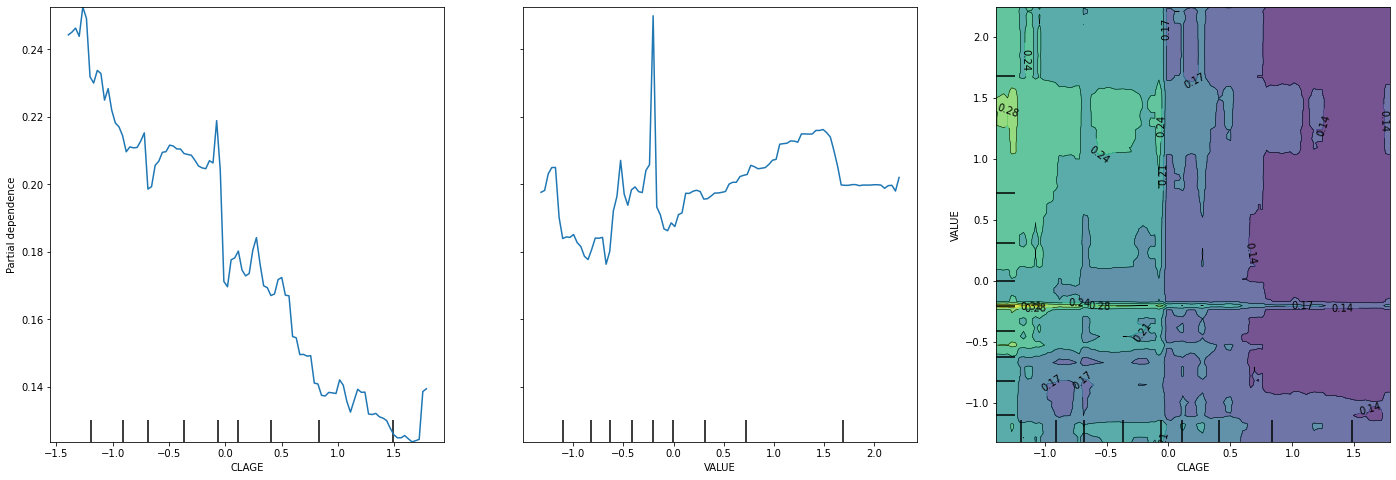

In [12]:
# WARNING takes a long time to execute (e.g., ~ 8 min on Google Colab)
plt.rcParams['figure.figsize'] = 24,8
plot_partial_dependence(classifier, X_train, features=['CLAGE', 'VALUE', ('CLAGE', 'VALUE')], feature_names=X_var_labels)

Based on the example, it is easy to see that you could use the function to create a PDP for each feature in one call. You would simple call `plot_partial_dependence(classifier, X_train, features=X_var_labels, feature_names=X_var_labels)`. The resulting plot matrix will potentially be very large (one plot per feature) so you better make sure that your figure size is large enough. Further, when analyzing this many plots it is useful to keep in mind what kind of patters you look for. Monotonic increase or decrease indicates a consistent feature-to-target relationship. A horizontal line indicates that predictions do not change with feature value, evidencing that the feature might be irrelevant and can potentially be discarded. Nonlinear patters are worth further investigation. For example, are we ready to accept a nonlinearity in the feature-to-target relationship given our domain expertise?     

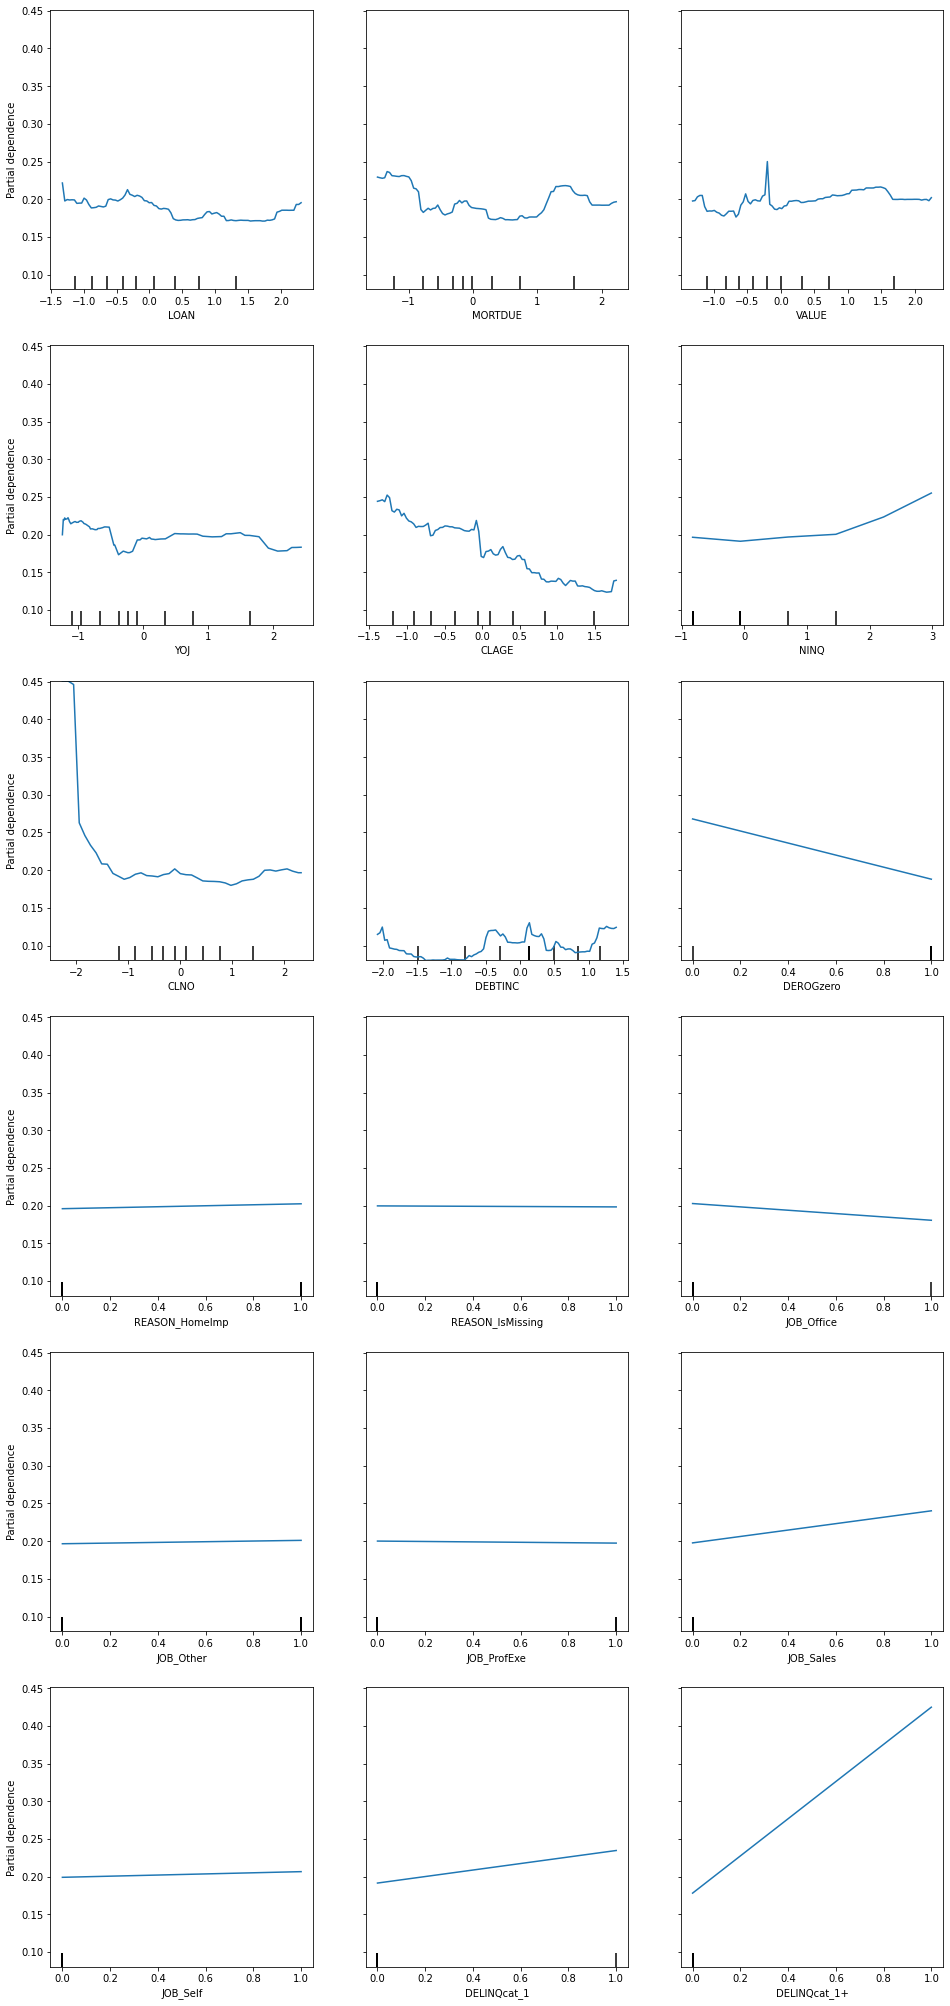

In [13]:
plt.rcParams['figure.figsize'] = 16,36
plot_partial_dependence(classifier, X_train, features=X_var_labels, feature_names=X_var_labels);

To conclude the part on PDP, let us re-emphasize the power of using permutation-based feature importance analysis and PDP together. We have extensively discussed one concrete application (checking the direction of a feature effect) above. In addition, an analysis of a PDP for *boundary feature* can be insightful. Assume you want to use permutation-based feature importance analysis for feature selection. So you will discard features that are less relevant to your model. Let's one once more inspect the result of the previous permutation-based feature importance analysis. Specifically, we reuse the result and simply re-produce a simpler version of the plot by exchanging the box-plot with a horizontal bar plot. 

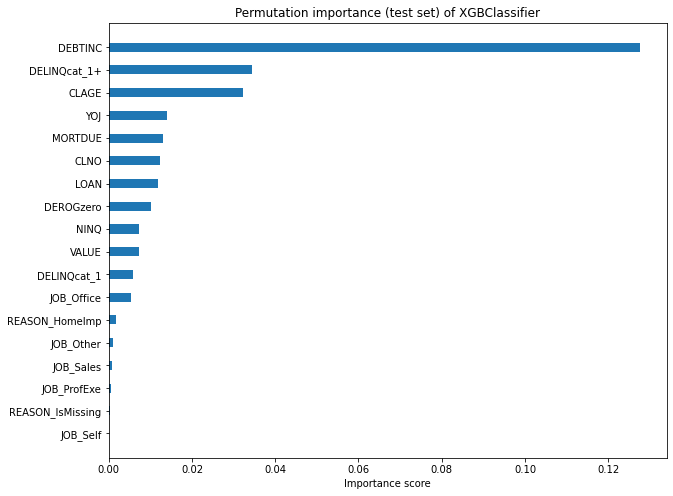

In [15]:
# Feature importance RF
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(y=np.arange(len(X_var_labels)), width=np.mean(perm_imp.importances[sorted_idx].T, axis=0), height=0.4)
ax.set_yticks(np.arange(len(X_var_labels)))
ax.set_yticklabels(X_var_labels[sorted_idx])
ax.set_xlabel('Importance score')
ax.set_title("Permutation importance (test set) of {}".format(str(classifier)[0:str(classifier).find('(')]))
plt.show()

OK, let's continue with our **feature selection use case**. Having obtain this result from the permutation-based feature importance analysis, you would clearly keep the feature DEBTINC. It is by far most relevant. The next two most important features, DELINQcat_1+ and CLAGE also look important. More specifically, we can look for *breaks* in the importance distribution. One breaks comes right after the top most important features. DELINQcat_1+ and CLAGE may be seen as the *second group of features*. Their importance does not differ much, they are clearly less important than DEBTINC, and substantially more important than YOJ and following. Hence, we can consider them a *group* in the importance score distribution. Spotting such groupings is subjective. We'd suggest that the next group of the third most important features encompasses YOJ and all features with lesser importance up to JOB_Office. You might have a different opinion but for the sake of the illustration let's stick to that view. Then, we also see one last group of least important features from REASON_HomeImp up to JOB_Self. In summary, we spot - subjectively - four groups of features with decreasing importance. 

The groups inform our feature selection. We could build candidate models incorporating only features of the top group, then group 1 and 2 together, then group 1 - 3, and finally a candidate model incorporating all features. That is perfectly fine. In addition or alternatively, it could be useful to check the PDPs of adjacent features from two groups. For example, above we saw the PDP of CLAGE and it clearly showed a consistent, plausible trend. This further confirms that CLAGE is important. You would want to have it in your model. Therefore, you do not have to test the candidate model with the second group of features at all. Let's check the PDP of YOJ, which comes right *after* CLAGE. If that PDP were suggesting that YOJ is not relevant you could conclude that features that are less important than  YOJ (i.e., based on the permutation-based analysis) can also not be relevant. Then, two checks of the PDP of CLAGE and YOJ would have solved your feature selection problem. By the way, how does the PDP of YOJ actually look like?

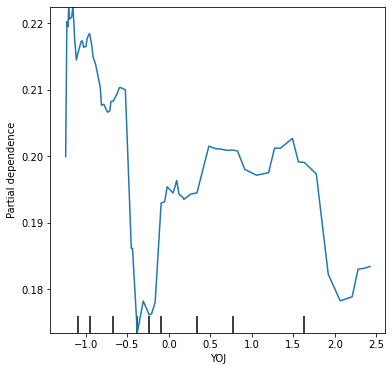

In [15]:
plt.rcParams['figure.figsize'] = 6,6
plot_partial_dependence(classifier, X_train, features=['YOJ'], feature_names=X_var_labels)
plt.show()

Well, this might be taken as moderate evidence that the feature might be informative. Specifically, one might *see* on a negative trend in the PDP and conclude that larger values of YOJ tend to decrease default probability predictions. If this is your interpretation, you could next examine the PDPs of the two features representing the least important feature from the third group (JOB_Office) and the most important feature of the fourth group (REASON_HomeImp). 

The way of selectively examining PDPs of features where permutation-based importance differs substantially is **entirely heuristic**. There is no guarantee that the PDP of a feature that came out as important in the permutation-based analysis also shows a clear trend in a PDP. The best example is the PDP of the feature DEBTINC (see below). DEBTINC is by far the most important feature according to permutation-based importance. Still we do not see a clear trend in the PDP. 

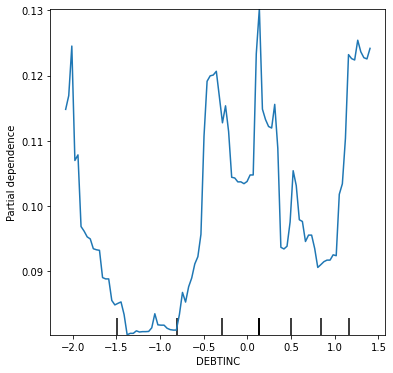

In [16]:
plot_partial_dependence(classifier, X_train, features=['DEBTINC'], feature_names=X_var_labels)
plt.show()

Inconsistent results like the one above, high feature importance but erratic PDP, occur when working with real word data. Our data set is small, which further increase the risk of inconsistent patterns in a PDP due to lack of data. However, with all those disclaimers, it is true that *an important* feature should be related to the target and a PDP should disclose this relationship provided the model has learned the relationship successfully. This is to say that the heuristic approach which we have been demonstrating above, how to use permutation-based feature importance analysis and PDPs together for feature selection, is conceptually sound. In practice, it might be easier to try out models with different feature subsets. From a computational point of view, the deciding factor might be whether it is faster to train and assess a candidate model or whether to produce a PDP. However, you could also adopt a different perspective by arguing that you would want to check both predictive performance and consistency in the feature-to-target relationship (by means of the PDP) before putting a model into production. In summary, PDPs are a useful instrument for diagnosing models. We also mentioned extensions in the lecture including, for example, ICE plots. Note that the function we have been using so much by now also supports ICE plots. Let's conclude this part with an example of an ICE plot, which requires setting the argument `kind` to `individual` as follows. 

Note that running the code might break because it requires version `0.24` of `sklearn` and is not supported by older versions. In case you cannot run the code, here is an [example](https://scikit-learn.org/stable/modules/partial_dependence.html#individual-conditional) how the output would look like.  

(<sklearn.inspection._plot.partial_dependence.PartialDependenceDisplay at 0x7f38106f0780>,)

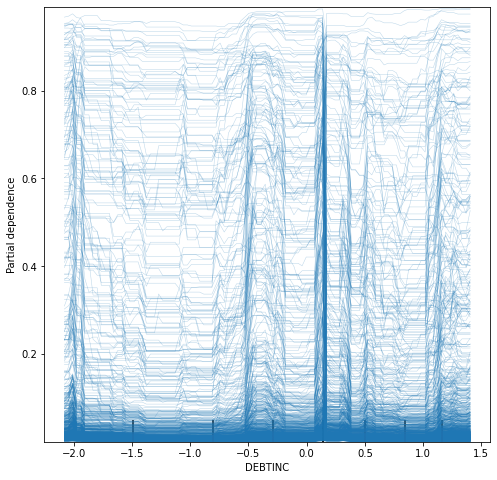

In [17]:
plot_partial_dependence(classifier, X_train, features=['DEBTINC'], feature_names=X_var_labels, kind='individual'),

Comparing the PDP and ICE for the feature DEBTINC is useful to understand the differences between the two plots and get a deeper understanding of how the classifier uses that variable. For example, we can see that the overal trend, which the PDP shows is clearly visible in the ICE. This was to be expected. The additional insight from the ICE concerns the fact that for several data points (shown as individual lines in the ICE plot) deviate from the norm. This hints at some interactions of the DEBTINC feature with other features. For example, interactions could explain why the probability of default, which is typically low when DEBTINC is low, can be as high as 80 percent or more even if DEBTINC is low. However, another way to interpret the plot is that the beneficial effect of a low DEBTINC may be overruled by other feature values, which lead to high default predictions. Interpreting a BB classifier is not trivial. The ICE plot is only one piece in the puzzle. Thus, we cannot find out which of the two interpretations is more plausible based on the ICE plot of one variable alone. 

# Local Interpretability 
All techniques discussed up until here aim at interpreting a model at large. Therefore, they belong to the family of global interpretation methods. The lecture also introduced local interpretability and the LIME approach. The following parts of the notebook elaborate on LIME and demonstrate application of SHAP, the other method mentioned in the lecture. 

## Local Interpretable Model-Agnostic Explanations (LIME)
[Ribeiro et al. (2016)](https://doi.org/10.1145/2939672.2939778) introduce the concept of local interpretable model-agnostic explanations (LIME) and provide a concrete implementation that concept. Their [Github repository](https://github.com/marcotcr/lime) provides the source code used for the paper and offers many useful examples and "how-to's". We strongly encourage you to check out the repository if you are interested in the LIME framework and consider using it in your studies/research/business setting. That said, comprehending their code is a little challenging because it offers the full set of functionality LIME has to offer, including, for example, extracting explanations from prediction models for text and image data. Below, we will briefly revisit the LIME framework, which we introduced in the lecture, and present a from-scratch implementation for tabular data. We use synthetic data in two-dimensions to reproduce some of the plots shown in the paper and offer some additional visualization to understand the functioning of LIME and some of its issues.

So let's start by revisiting the LIME framework and, in particular, the different attributes of the approach. The attribute *local* stands for local interpretation, meaning that our focus is the explanation of the model prediction of one particular observation (i.e., data point). Model-agnostic means that LIME supports any prediction model or learning algorithm. You can explain the predictions of an XBG classifier, a random forest classifier, a neural network based regression models, etc. This flexibility is achieved by using only the input (data) and output (prediction) of a model. What is going on within the model does not matter. 

Beyond black-box (BB) model inputs and outputs, LIME also requires an explanation model to explain the outputs (predictions). The explanation model has to be intrinsically interpretable and is typically chosen to be a linear model; although a tree would also work. As a quick recap, let's take a look at the pseudo-code from the lecture.

**Pseudo Code for LIME**

```
0. Select your instance of interest (input parameter of the function, not necessary for writing the functions source code)
1. Perturb your dataset (synthetic data)
2. Get the black box predictions for the new, synthetic data points
3. Weight the new data points according to their proximity to the instance of interest
4. Train a weighted, interpretable model (the explanation model) on the labeled, synthetic data points
5. The explanation models (e.g., linear regression function) reveals how feature values are translated into predictions. By construction, it approximates how the BB model performs this translation in the neighborhood of the focal instance. 
```

### LIME procedure
The LIME algorithm is implemented in the function `LIME_demo ()`. The function essentially consists of five steps.

#### 1. Synthetic data
Synthetic data is required to estimate the interpretable model. In this example, we use randomly selected normally distributed values. For each of the two features, the parameters of the normal distribution are specified according to the mean value and the standard deviation of this feature in the classification data.
#### 2. Prediction by BB model
A target variable is required for the interpretable model. For this purpose, we use the previously generated synthetic data as input to the trained BB model to make predictions. The target variable then corresponds to the estimate  $ \hat{p} \left( y_j=1|Z_j \right) $ by the BB model.

#### 3. Neighborhood and weighting
The synthetic data is weighted according to their distance to the test instance. We use the Euclidean distance $D\left(X_i,Z_j\right)=||X_i-Z_j||_2$. This is equal to the standard for structured data in the [official LIME package](https://github.com/marcotcr/lime). With the help of calculating these distances, we define the test instance's neighborhood. Following the standard of the LIME package,  an exponential core function is used. 
$$ \pi_{X_i}\left( Z_i \right)=\exp \left( - \frac{D\left(X_i,Z_j\right)}{\sigma^2}\right)$$

#### 4. Estimation of the interpretable model
We use a linear model to explain the test instance's BB prediction. LIME uses a regularized linear model by default. In this example, as we only use two features, we don't use regularization and use a multivariate linear regression model for the interpretation instead. We estimate this model by minimizing the * weighted * likelihood function.

$$ \mathcal{L} \left( f, g, \pi_{X_i} \right) = \sum_{j=1}^{J} \pi_{X_i}\left( Z_i \right) \left( f\left( Z_j \right)- g \left( Z_j \right)  \right)^2 $$

#### 5. Output of the results
The function provides various results, which stem from the paper by [Ribeiro et al. (2016)](https://doi.org/10.1145/2939672.2939778) and the [official LIME package](https://github.com/marcotcr/lime) This includes the prognosis of the test instance by the BB model as well as the interpretable model and a series of graphics that illustrate the functionality of LIME. For more details, please refer to the function's source code directly.


### LIME from scratch

#### Function `LIME_demo ()`

In [ ]:
# Import libraries

# Plotting
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
# Some configuration of the plots we will create later
%matplotlib inline  
class_coloring = plt.cm.bwr

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression


import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [ ]:
def LIME_demo(X, y, test_point, BB_model, n_syn_data, kernel_width, rep_paper_plot=True, fname=None):
    """
    Simplified implementation of the LIME-method following the paper of Ribeiro et al. (2016)
    http://doi.org/10.1145/2939672.2939778
    
    Input parameters:  X = matrix of independent variables for the classification task 
                       y = vector of values of the target variable of the cases in X 

                       test_point = the instance to be explained
                       
                       BB_model = sklearn object of a trained classifier
                       
                       n_syn_data = number of synthetic data point (sample size) 
                       
                       kernel_width = parameters of the expoential core function

                       reg_paper_plot = boolean value. If true, the function outputs four plots
                                        based on the LIME paper. Otherwise an individualized 
                                        output consisting of six plots is generated.
                          
                                        
                      fname = Name of image file (path specification possible) the plots should
                              be saved as. If <None> no file will be saved.
    
    Author: Stefan Lessmann (stefan.lessmann@hu-berlin.de)
    
    License: BSD 2-clause "Simplified" license 
    
    Version: Januar 2021
    """    
    # *******************************************************************************************
    # 
    # Step 1: Generate synthetic data
    # 
    # *******************************************************************************************
    # For tabular data, the proximity to the test instance is irrelevant at this point. The data
    # is generated as random, normally distributed values. The two features are uncorrelated.
    np.random_state = rnd_state
    X_syn = np.random.normal(loc=0, scale=1, size=n_syn_data*2).reshape(n_syn_data, 2) # Normally distributed random variable
    # Scaling of the corresponding data
    X_syn = X_syn * np.std(X, axis=0) + np.mean(X, axis=0)
    # Update of the scaling of the coordinate system for graphic representations
    xy_limits = plot_get_limits( np.row_stack((X, X_syn)), delta=0)  
    # *******************************************************************************************
    # 
    # Step 2: Predicting the synthetic data with the BB model to obtain a target variable for 
    #         the explanatory model
    # *******************************************************************************************
    y_syn = BB_model.predict_proba(X_syn)[:,1]
    # *******************************************************************************************
    # 
    # Step 3: Determine the distance between the test instance and the synthetic data points.
    #         This is how the neighborhood is estimated.  
    # 
    # *******************************************************************************************
    dist = pairwise_distances(X_syn, test_point).ravel()  # Pairwise distance to test instance
    weights = np.sqrt( np.exp(-(dist ** 2) / kernel_width ** 2))  # Neighborhood
    # *******************************************************************************************
    # 
    # Step 4: Estimate the linear interpretable model on the synthetic data. Since there are only 
    #         two features, we do not regularize the linear regression model.
    # 
    # *******************************************************************************************
    lin_reg = LinearRegression(fit_intercept=True)   
    WB_model = lin_reg.fit(X_syn, y_syn, sample_weight=weights)  # Min. weighted LL-function
    y_wb_syn = WB_model.predict(X_syn)  # Prediction of interpretable model
    resid = y_syn - y_wb_syn            # and the residuals
    # *******************************************************************************************
    # 
    # Step 5: Output of the results
    # 
    # *******************************************************************************************   
    # Textual summary
    print('Test instance: ', test_point)
    print('Parameter of the WB model: ', WB_model.coef_.ravel(), WB_model.intercept_)
    print('Weighted squared residual = {:.4}'.format(np.sum((resid**2)*weights)/len(y_syn)))
    print('Prediction of test instance of the BB model {}'.format(BB_model.predict_proba(test_point)[:,1]))
    print('Approximation of WB model {}'.format(WB_model.predict(test_point)))
    print('\n\n')
    #--------------------------------------------------------------------------------------------
    # Visiualization
    #--------------------------------------------------------------------------------------------
    if rep_paper_plot:
        plot_reproduce_paper(test_point, syn_x=X_syn, syn_weights=weights, bb_model=BB_model, wb_model=WB_model, img_name=fname)
    else:
        plot_lime_steps(test_point, X, y, syn_x=X_syn, syn_y=y_syn, syn_weights=weights, bb_model=BB_model, wb_model=WB_model, img_name=fname)

#### Functions for plotting

In [ ]:
def plot_get_limits(D, delta=0.25):
    x1_lim = (np.min(D[:,0])-delta, np.max(D[:,0])+delta)
    x2_lim = (np.min(D[:,1])-delta, np.max(D[:,1])+delta)
    
    return (x1_lim, x2_lim)

In [ ]:
def plot_init_axis(ax, title=None):
    
    if not title is None:
        ax.set_title(title, fontsize=16)
    ax.set_xlim(xy_limits[0][0], xy_limits[0][1])
    ax.set_ylim(xy_limits[1][0], xy_limits[1][1])
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.set_xlabel('$x_1$', fontsize=14)

In [ ]:
def plot_reg_line(ax, beta, bias, lw=5):
    # Plotting data
    x1 = np.linspace(xy_limits[0][0], xy_limits[0][1]) 
    x2 = - beta[0] / beta[1] * x1 - bias/beta[1]
    # Clipping
    ix = [i>xy_limits[1][0] and i < xy_limits[1][1] for i in x2]
    #ix = [i>x2_lim[0] and i < x2_lim[1] for i in x2]
    reg_line = np.c_[x1[ix], x2[ix]]
    # Plotting
    ax.plot(reg_line[:,0], reg_line[:,1], linewidth=lw, c='#FFFF00')
    return reg_line

In [ ]:
def plot_data(ax, X, y, alpha=1, X_test=None, y_test=None):
    """ 2D plot of classification task"""
   
    # Plot the training & test points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=class_coloring, edgecolors='k', marker='o', alpha=alpha)
    #ax.set_xlabel("$x_1$")
    #ax.set_ylabel("$x_2$")
    if X_test is not None and y_test is not None:
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=class_coloring, edgecolors='k', marker='*', s=150, alpha=alpha)

In [ ]:
def plot_synthetic(ax, X, y=None, weight=None, add_bar=False):
    """ 2D plot of classification task"""
    
    a = 0.7

    if y is None:
        ax.scatter(X[:,0], X[:,1], marker='^', c='k', s=weight, alpha=a)
    else:
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=class_coloring, edgecolors='k', marker='^', s=weight, alpha=a)

    if add_bar:
        ax_c = plt.colorbar(plt.cm.ScalarMappable(cmap=class_coloring))
        ax_c.set_label("BB-Modell estimate of $p(y=1|X)$")
        ax_c.set_ticks([0, .25, .5, .75, 1])
        

In [ ]:
def mesh_grid_orig(model, res = 0.01, mode='classification'):
    res = 0.01 # step size in the mesh
   
    xx, yy = np.meshgrid( np.arange(xy_limits[0][0], xy_limits[0][1], res),
                          np.arange(xy_limits[1][0], xy_limits[1][1], res)
                        )   
    if mode == 'classification':
        y_hat = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    elif mode =='regression':
        y_hat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        raise(BaseException('The mode {} is not supported.'.format(mode)))
    y_hat = y_hat.reshape(xx.shape)
    return (xx, yy, y_hat)

In [ ]:
def mesh_grid_data(res = 0.01):
    
    xx, yy = np.meshgrid( np.arange(xy_limits[0][0], xy_limits[0][1], res),
                          np.arange(xy_limits[1][0], xy_limits[1][1], res)
                        )   
    
    return (xx, yy)

In [ ]:
def mesh_grid_prediction(model, res = 0.01, mode='classification'):
   
    data = mesh_grid_data(res)
    
    if mode == 'classification':
        y_hat = clf.predict_proba(np.c_[data[0].ravel(), data[1].ravel()])[:, 1]
    elif mode =='regression':
        y_hat = clf.predict(np.c_[data[0].ravel(), data[1].ravel()])
    else:
        raise(BaseException('The mode {} is not supported.'.format(mode)))
    y_hat = y_hat.reshape(data[0].shape)
    return (data[0], data[1], y_hat)

In [ ]:
def plot_decision_surface(ax, clf, data=None, add_bar=False, binarize=False):
    
    if data is None:
        x1, x2, y_hat = mesh_grid_prediction(clf)
    else:
        (x1, x2, y_hat) = data
        
    if binarize:
            y_hat = y_hat >= 0.5
            
    contour = ax.contourf(x1, x2, y_hat, cmap=class_coloring, alpha=.5) # , vmin=0, vmax=1
    
    if add_bar:
        ax_c = plt.gcf().colorbar(contour)
        ax_c.set_label("$P(y=1|X)$")
        ax_c.set_ticks([0, .25, .5, .75, 1])
        

In [ ]:
def plot_instance(ax, xi=None):
    """ Plot of the observation to be explained"""
    if xi is None:
        xi = Xi
        
    ax.scatter(xi[0,0], xi[0,1], marker='o', c='#FFFF00', edgecolors='k' ,s=250)           

In [ ]:
def plot_wb_model_grid(ax, wb_model, resolution=0.2):
    data = mesh_grid_data(res=resolution)
    data = np.c_[data[0].ravel(), data[1].ravel()]
    y_hat = wb_model.predict(data)

    ax.scatter(data[y_hat>0,0], data[y_hat>0,1], c='r', marker='x')
    ax.scatter(data[y_hat<0,0], data[y_hat<0,1], c='b', marker='x')

In [ ]:
def plot_explanation(ax, wb_model):
    dim = len(wb_model.coef_)
    labels = ('x1', 'x2')
    barcolor = np.repeat('r', dim)
    for i, w in enumerate(wb_model.coef_):
        if w < 0:
            barcolor[i]='b'

    y_pos = np.arange(dim)        
    ax.barh(y_pos, wb_model.coef_, align='center', color=barcolor)
    ax.set_xlabel('Coefficient of the interpretable model', fontsize=14)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)

In [ ]:
def plot_reproduce_paper(test_instance, syn_x, syn_weights, bb_model, wb_model, img_name=None):
    """
    The replicated main plot from the paper by Ribeiro et al. (2016), which illustrates the 
    functionality of lime
    """
    # 2x2 matrix of plots 
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(26, 26))
    axs = axs.reshape(-1)
    # 1. Decision function of the BB model
    plot_init_axis(axs[0], 'A')
    plot_decision_surface(axs[0], bb_model)
   
    # 2. Decision function of the BB model, synthetic data (unweighted and without label) and test instance
    plot_init_axis(axs[1], 'B')
    plot_decision_surface(axs[1], bb_model)
    plot_instance(axs[1], xi=test_instance)
    plot_synthetic(axs[1], syn_x)
    
    # 3.  Decision function of the BB model, synthetic data (weighted without label) and test instance
    plot_init_axis(axs[2], 'C')
    plot_decision_surface(axs[2], bb_model)
    plot_instance(axs[2], xi=test_instance)
    plot_synthetic(axs[2], syn_x, weight=syn_weights*100)
    
    # 4. Decision function of the BB model, approximation by the interpretable model, test instance and grid with classification of linear model
    plot_init_axis(axs[3], 'D')
    plot_decision_surface(axs[3], bb_model)
    plot_instance(axs[3], xi=test_instance)
    plot_reg_line(axs[3], wb_model.coef_, wb_model.intercept_)
    plot_wb_model_grid(axs[3], wb_model)
    
    if img_name is not None:
        plt.savefig(img_name, format='jpg')
    

In [ ]:
def plot_lime_steps(test_instance, data_x, data_y, syn_x, syn_y, syn_weights, bb_model, wb_model, img_name=None):
    """
    Visualization of LIME steps; inspired by the main plot from the paper by Ribeiro et al. (2016)
    """
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(26, 26), sharey=False)
    axs = axs.reshape(-1)
    ix = 0
    
    # Classification task
    plot_init_axis(axs[ix], 'Classification task and decision function of the BB model')
    plot_data(axs[ix], data_x, data_y)
    ix += 1
        
    # Decision function of the BB model
    plot_init_axis(axs[ix], 'Decision function of the BB model')
    plot_data(axs[ix], data_x, data_y)
    plot_decision_surface(axs[ix], bb_model)
    ix+= 1
      
    # Test instance and synthetic data (unweighted, without label)
    plot_init_axis(axs[ix], 'Test instance and synthetic data (random, normally distributed values)')
    plot_decision_surface(axs[ix], bb_model)
    plot_instance(axs[ix], xi=test_instance)
    plot_synthetic(axs[ix], syn_x)
    ix += 1
    
    # Weighting of synthetic data
    plot_init_axis(axs[ix], 'Synthetic data weighted by distance')
    plot_decision_surface(axs[ix], bb_model)
    plot_instance(axs[ix], xi=test_instance)
    plot_synthetic(axs[ix], syn_x, weight=syn_weights*100)
    ix += 1
    
    # Distribution of target variable
    axs[ix].set_title('Distribution of target variable for the WB model', fontsize=16)
    axs[ix].hist(y_syn)
    ix += 1
    
    # Synthetic data with label
    plot_init_axis(axs[ix], 'Synthetic data incl. label by prediction through the BB model')
    plot_instance(axs[ix], xi=test_instance)
    plot_synthetic(axs[ix], syn_x, syn_y, weight=syn_weights*100, add_bar=True)
    plot_reg_line(axs[ix], wb_model.coef_, wb_model.intercept_)
    ix += 1
   
    plt.show()
    fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(26, 10), sharey=False)
    axs = axs.reshape(-1)
    ix = 0
    
    # Linear, local approximation of BB model
    plot_init_axis(axs[ix], 'Linear, local approximation of BB model')
    plot_decision_surface(axs[ix], bb_model)
    plot_instance(axs[ix], xi=test_point)
    plot_reg_line(axs[ix], wb_model.coef_, wb_model.intercept_)
    plot_wb_model_grid(axs[ix], wb_model)
    ix += 1

    # LIME explanation
    axs[ix].set_title('LIME explanation', fontsize=16)
    plot_explanation(axs[ix], wb_model)
    
    if img_name is not None:
        fig.savefig(img_name, format='jpg')
        
    plt.show()

#### Configuration

Test instance:  [[1.  0.5]]
Parameter of the WB model:  [ 0.12098656 -0.60681811] 0.4771900416606363
Weighted squared residual = 0.02778
Prediction of test instance of the BB model [0.00253911]
Approximation of WB model [0.29476754]





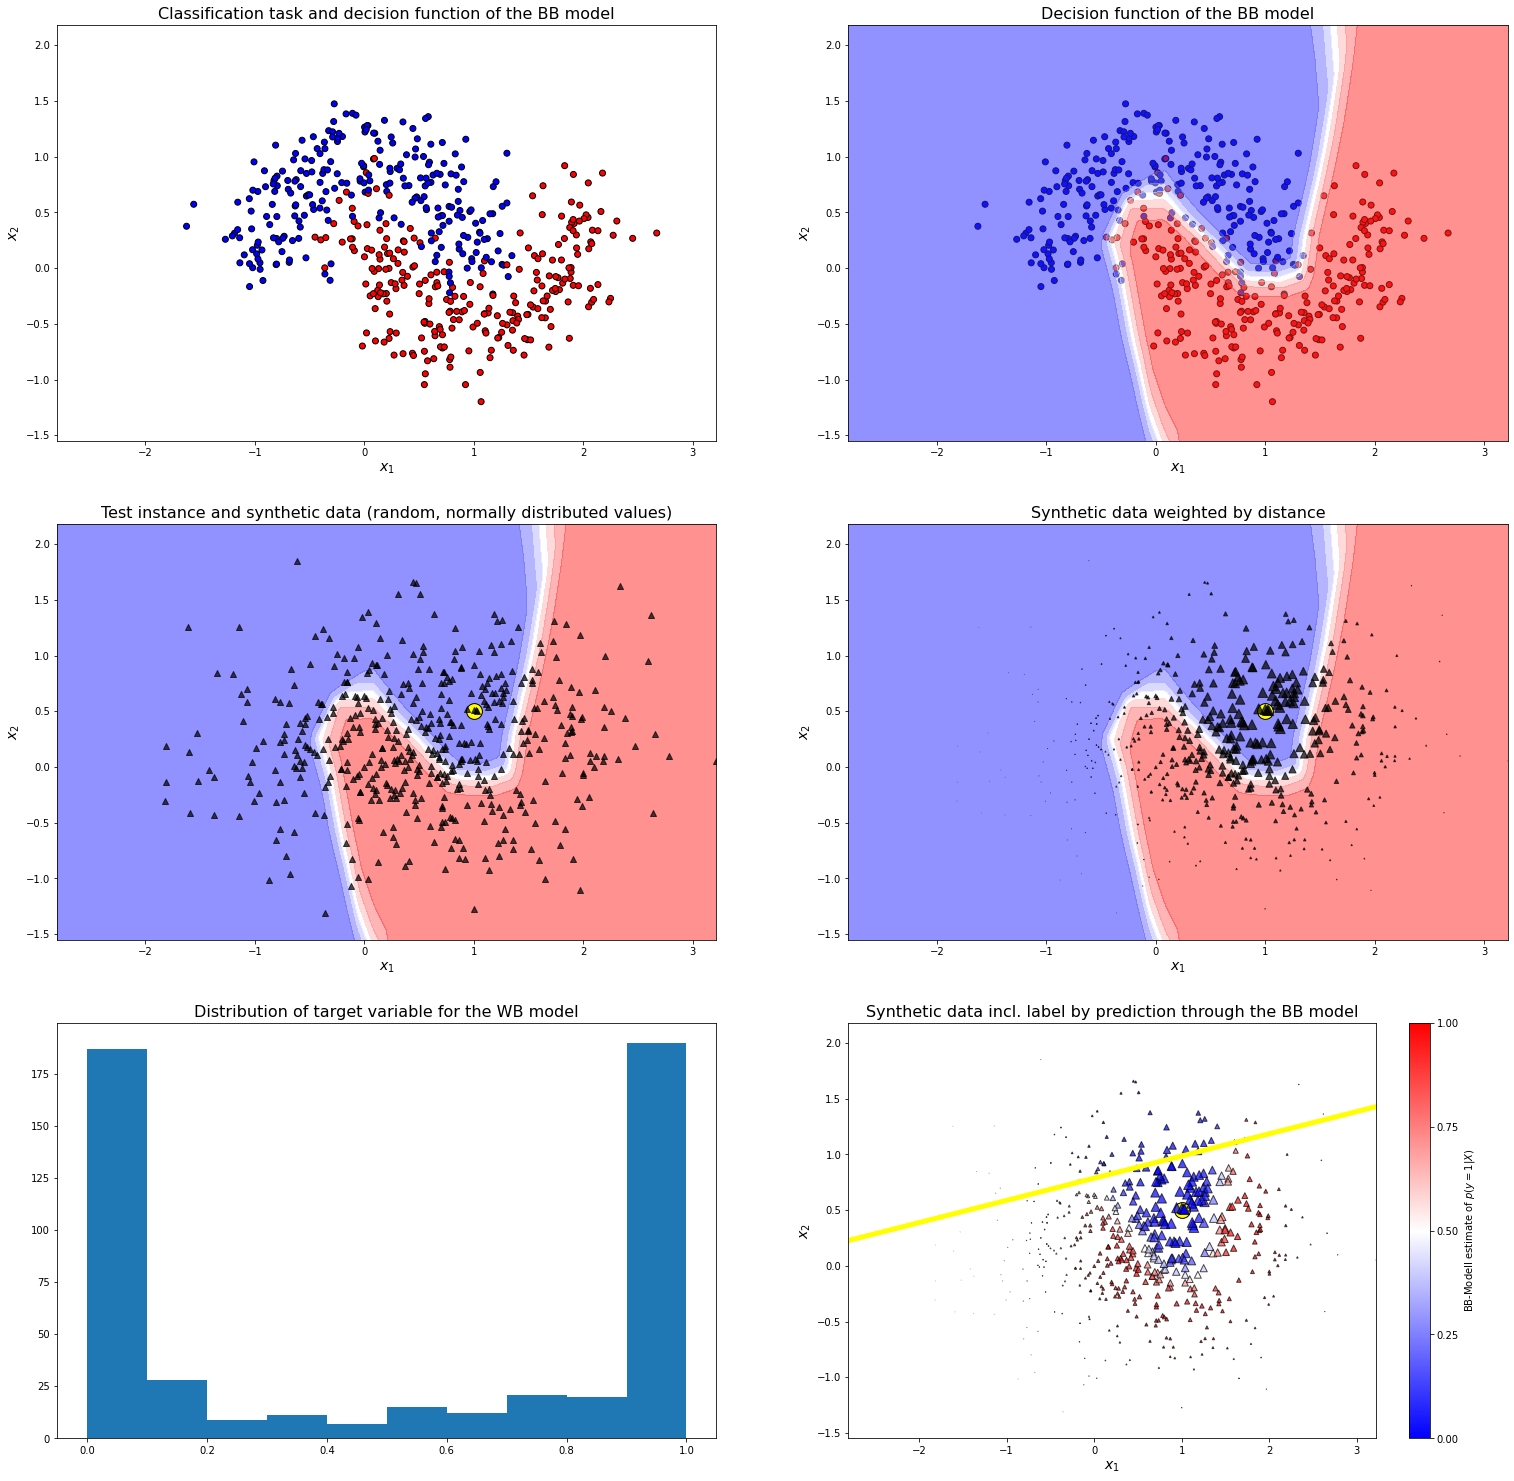

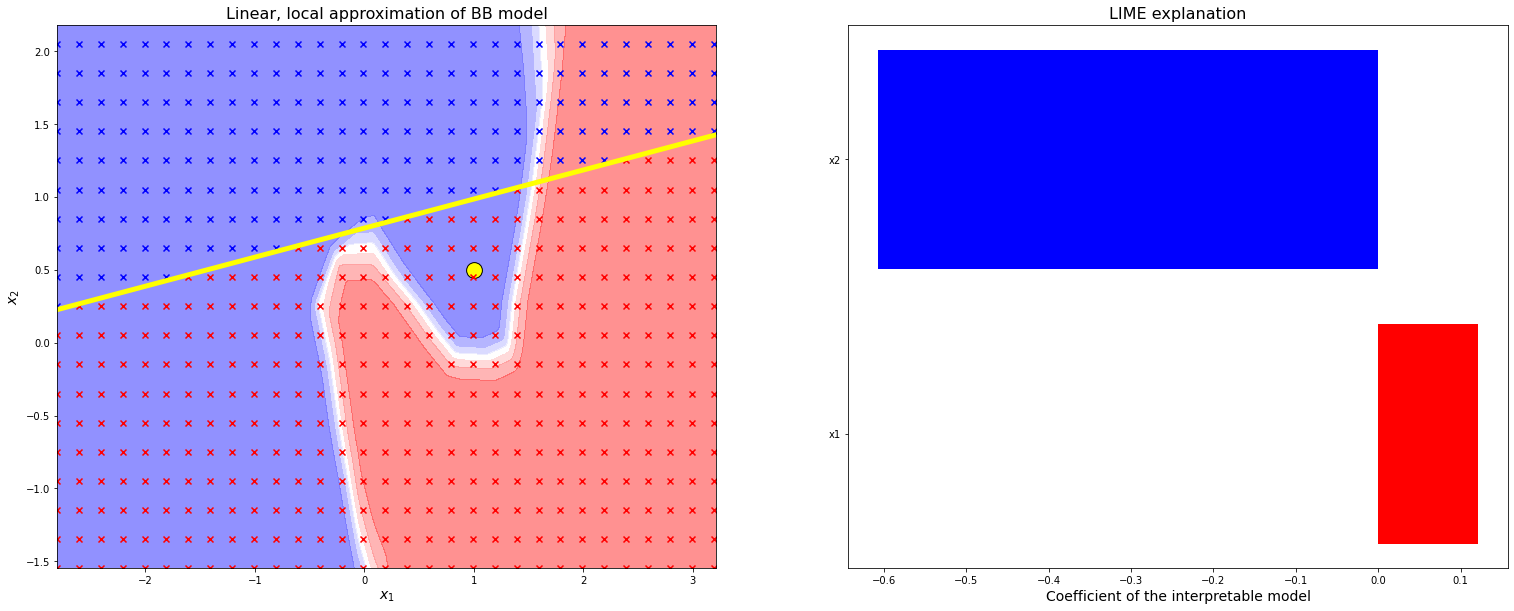

In [ ]:
# Original data for the classification task
n_real_data = 500 # Anzahl der Fälle 

# Ripley data set (simple linear classification task)
# X, y = make_Ripley(n=n_real_data, mu1=[0,0], mu2=[3, 3], sig1=2, sig2=1)

# Moon data set (non linear classification task)
X, y = make_moons(n_samples=n_real_data, noise=0.25, random_state=rnd_state)

# Synthetic data for the estimation of the interpretable model
n_syn_data = 500  # Sample size for synthetic data that should get generated by LIME
kernel_width = 0.5 # Parameter \sigma for exponential core function
mean_x = np.mean(X, axis=0) # added 
s_x = np.std(X, axis=0)     # added
np.random_state = rnd_state # added
X_syn = np.random.normal(loc=0, scale=1, size=n_syn_data*2).reshape(n_syn_data, 2) # added
X_syn = X_syn * s_x + mean_x # added

# Non-linear classifiers (BB-Modelle)
#clf = XGBClassifier(learning_rate=0.01, n_estimators=250, random_state=rnd_state)
#clf = MLPClassifier(random_state=rnd_state)
clf = MLPClassifier(hidden_layer_sizes=(100, 25), max_iter=500, random_state=rnd_state)

# Fitting BB model
BB_model = clf.fit(X, y)
y_syn = BB_model.predict_proba(X_syn)[:,1]

# Observation to be explained
test_point = [1, 0.5] #[1.75, 0.75] 
test_point = np.array(test_point).reshape(1, -1)  

xy_limits = plot_get_limits( np.row_stack((X, X_syn))) # added 

LIME_demo(X, y, test_point, BB_model, n_syn_data, kernel_width, rep_paper_plot=False)

### The official LIME package

Next, we will install the [official LIME package](https://github.com/marcotcr/lime). This package, similar to the LIME from scratch above, is based on the paper by [Ribeiro et al. (2016)](https://doi.org/10.1145/2939672.2939778). It currently supports tabular data, textual data and image data. 

In [ ]:
# Chose row/ observation and extract values
test_point = 1
observation = X_test[test_point]

In [ ]:
# Load LIME package
import lime
from lime.lime_tabular import LimeTabularExplainer

# Generate LIME explainer function for tabular data
lime_explainer = LimeTabularExplainer(X_train, mode="classification", feature_names=list(X_var_labels), categorical_features=None, verbose=True, discretize_continuous=False)

# Features to show in plot
k=10 

# Prediction of RF model
pred_fun = rf.predict_proba  

# Call explainer function
exp_rf = lime_explainer.explain_instance(data_row=observation, predict_fn=pred_fun, num_features=k)
# Output results
exp_rf.show_in_notebook(show_table=True, show_predicted_value= True)

Intercept 0.20658828705403018
Prediction_local [0.19226645]
Right: 0.5053864455148961


In [ ]:
# Repeat for XGB
pred_fun = xgb.predict_proba
exp_xgb = lime_explainer.explain_instance(data_row=X_test[test_point], predict_fn=pred_fun, num_features=k)
exp_xgb.show_in_notebook(show_table=True, show_predicted_value= True)

Intercept 0.11788349102978239
Prediction_local [0.1146729]
Right: 0.6805318


**How to read this plot:** <br>
This plot depicts:
- left plot: the class probabilities for class 0 (in blue) and class 1 (orange) 
- central plot: the contributions (blue contributes to class 0, orange to class 1) of the features to the prediction, corresponding to the weights of the linear model
- right plot: the actual values for each feature for the given observation ranked by their importance on the right

*For example*, in the XGB plot, the observation we are inspecting had a value of 0.14 for DEBTINC. This value is approximated to have affected the output the most, with a value of 0.07, pushing it towards class 1.

**When to use this plot:** <br>
This model is helpful when we want to take a closer look at a single observation. For example, a person applied for a loan at the bank. We estimate their default risk to be 0.68 according to our XGB model and 0.51 for our RF model. This is relatively high for the given scenario, so we chose to review this decision. A professional with the given domain knowledge can look at how the features have affected the output and use this plot as an aid for decision-support to make the final decision. For example, as seen in prior, the feature DEBTINC is of high importance. Having a debt-to-income ratio of 0.14 has had a strong positive effect on our output. This is reasonable as the higher the debt compared to the income, the less likely a person might be to pay back their loan.

# Shapley Additive Explanations

Next, we will discuss SHAP (SHapley Additive exPlanations). SHAP is also a local model-agnostic explanation method.  The concept of the fair payout in a coalition, that is the Shapley value, was introduced in the scope of cooperative game theory. The Shapley value captures the contribution a player makes to the outcome. <br> *When is this useful?* For example, if a football team wins a game that includes a cash price and wants to distribute this between the players based on their contribution to the result. <br> *How can we use this technique for model explanation?* In a data science use case, our players are the features and the outcome is the prediction. So, we want to calculate the contribution of each feature to the prediction. <br>  *How is this achieved?* In a nutshell, this is done by changing the data slightly, and observing how the output changes and then estimating how high each feature's contribution is to the prediction. Using SHAP values for interpretable machine learning was first proposed by [Lundberg & Lee (2017)](https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html).

For this part of the tutorial, we will use the [SHAP package](https://github.com/slundberg/shap) to apply this method. If you are interested in learning how to write this function from scratch, please follow [this link](
https://afiodorov.github.io/2019/05/20/shap-values-explained/) for a detailed explanation.

### Calculate SHAP values

Before starting, we choose an observation we want to inspect. This is the same as in LIME. After all, both methods focus on - or rather start with - local interpretability. We simply chose an arbitrary sample from our data set. Feel free to change the corresponding variable `test_point` to explore a different observation. 

Next, we calculate the SHAP values. To that end, we make use of the `shap.TreeExplainer`, which receives a prediction model (e.g., fitted sklean model object) as input. More specifically, as the name states, this explainer accepts tree models as input and explains their prediction. It turns out that the computation of SHAP values is very costly. To cope with computational challenges, tailor-made way to approximate the Shapley value for specific types of prediction models are needed and include in the package (kindly refer to the [GitHub repositroy](https://github.com/slundberg/shap) for details). Having obtained an explainer object via `object = shap.TreeExplainer(model)`, we get the feature contributions by calling the `shap_values()` function, which receives as argument the focal data sample `X_test`. 

Whilst SHAP is a local explanation method, this package also facilitates calculating SHAP values for all observations and, as you will see shortly, provides graphical summaries of the entire SHAP values distribution to allow for global interpretation. Note that LIME offers a similar approach to aggregate over local explanations for obtaining a global estimate of feature importance. In this tutorial, we calculate the SHAP values for the full test data set and extract the values for our chosen observation when we need it. 
<br> <br>

**Important:** <br> 
The `shap.TreeExplainer` uses functions from the BB model that we use as an input to the explainer class. When you run the code `shap.TreeExplainer(rf)`, the default output is two arrays with SHAP values for the probability predictions for class 0 and class 1. This is similar to what we know from the `.some_model.predict_proba()` function. The XGB model, however, outputs log-odds by default and, therefore, only one array of SHAP values. In order to compare our models, we will set the `model_output='probability'` for the XGB model to achieve comparable results.

In [3]:
# Import shap 
import shap

In [4]:
# Chose row/ observation and extract values
test_point = 1

In [18]:
# Explainer algorithm  for tree models
explainer_rf = shap.TreeExplainer(rf)
explainer_xgb = shap.TreeExplainer(xgb, data=X_train, feature_perturbation='interventional', model_output='probability')

# Calculate SHAP values for all observations
shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_xgb = explainer_xgb.shap_values(X_test)

 96%|=================== | 1714/1788 [00:20<00:00]       

In [19]:
print("The shape of the RF model is: {}".format(np.shape(shap_values_rf)))
print("The shape of the XGB model is: {}".format(np.shape(shap_values_xgb)))

The shape of the RF model is: (2, 1788, 18)
The shape of the XGB model is: (1788, 18)


As you can see in the code above, our outputs still differ by the RF object containing two arrays and the XGB model containing only one. For the RF model, we will subset the array with the index 1, which gives us the corresponding SHAP values for the probability predictions of class 1 (`shap_values_rf[1]`). This is equivalent to the array of our `shap_values_xgb` variable and gives us the comparable output for the corresponding models.


The Shap framework provides a ton of visualizations to diagnose BB machine learning models. As indicated above, some analyses target local interpretatbility while others focus on global interpretability. Below, we will consider some typical use cases and illustrate the way in which they are supported by Shap. 

### SHAP plot
The *force-plot* is maybe the best known visualization of the Shap framework. Let's first create the plot and then discuss what it tells us.

In [20]:
# Local explanation SHAP plot for RF model
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][test_point], X_test.values[test_point], feature_names=X_var_labels )

In [21]:
# Local explanation SHAP plot for XGB model
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[test_point], X_test.values[test_point], feature_names=X_var_labels)

**How to read this plot:** <br>
This plot depicts:
- the expected value of the model (base value). Think of it as the average prediction of the model.
- the model prediction for the focal data point: above the scale
- each variable: by name
- the value of each feature: the number behind the feature name
- the feature's contribution to the prediction: size and color of arrow, blue for negative impact, red for positive. The size defines how big that feature's impact is. 
<br>

For example, the RF model predicts the default probability of the *test_point* to be 0.51. For this test point, the feature value for the feature DEBTINC had a value of 0.1375. This feature values increases the prediction substantially (e.g., more than any other feature). Apparently, the RF classifier has found a feature value of 0.1375 for DEBTINC to be associated with higher default risk. On the other hand, the occupation (JOB) of the test point was *professional executive*. Out of the feature values that lowered the RF model prediction, this was the feature value with the largest impact. Thus, credit applications who are professional executives tend to show lower risk of default; according to the RF classifier. Remember that we interpret model prediction. Strictly speaking, it is wrong to conclude that `JOB_ProfExe=1` implies lower default risk **from the plot alone**. The plot looks only into what the classifier *thinks* is true. This does not imply that an estimated feature-to-target relationship is correct. However, if we consider the classifier's performance on top of the above plot, we might be willing to conclude that `JOB_ProfExe=1` implies lower default risk. Why? Because we have seen that the RF classifier achieves high performance on the test set. Hence, the dependencies that it has estimated appear to be plausible, and the force plot reveals those dependencies for one specific test point.  

**When to use this plot:** <br>
This model can be used in the same scenario as the LIME plot above. Again, we have a relatively high risk of default for the given scenario and want to review which features influenced the final prediction, how and most importantly, *how much*. As we have seen in our global model analysis, both the RF and XGB model show the variable DEBTINC to have high importance to the model output. We see that it shows a high positive impact on the estimated default risk for both models, with a feature value 0.1375. Interestingly, this is in accordance with our PDP earlier, which shows a high partial dependence for features values around that. We also established that both CLAGE and DELINQcat+1 carry importance in the model building process. CLAGE shows a relatively high increase in default risk for the value 0.06103 for both models. DELINQ_cat_1+, however, has a much lower SHAP value for the XGB model as opposed to the RF model and, therefore, does not contribute much to the XGB model's final prediction for this observation. 
<br> *Why does a feature that has a high global feature importance have a low impact on a local explanation?* 
One reason might be that the impact a feature has on the prediction might depend on a feature value. This can be explained with a simple example, like a sickness, such as COVID-19. In this case, the symptoms are our features. Having a symptom, such as a dry cough, should significantly increase the risk of having COVID-19. However, not having a dry cough might not have a strong negative impact on the risk assessment, as various symptoms can be an indicator of this sickness. The same goes for our scenario. There can be different reasons as to why someone cannot pay back a loan. One reason might be fraud and another one financial instability. This way, different features can be important on a local level. A decision approximation for a whole model can be helpful but might be insufficient for the situation at hand. Here, local methods can give more insight. We will see more examples of this in the final plot of this tutorial, where we summarize the local estimates for each feature and all observations in one plot.

In [22]:
# RF full plot
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1], X_test, feature_names=X_var_labels)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
# XGB full plot
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb, X_test, feature_names= X_var_labels)

Output hidden; open in https://colab.research.google.com to view.

**How to read this plot:** 

This plot shows a summary of the plot shown above for **all** observations, simply rotated by 90 degrees. The y-axis shows which corresponding observation the horizontal stack of SHAP values refers to. The index of the observations depends on what you chose for the axes. The initial selection is "sample order by similarity", meaning observations with similar values are close to each other on the y-axis. We can run our mouse over this plot to get the exact corresponding output on the x-axis and the features with the highest absolute SHAP values.

*For example*, observation 0 shows a prediction of 1 for the RF model, with the features DEBTINC, DELINQcat_1+ and CLAGE having the highest absolute SHAP values. We can also read their corresponding feature values when hovering over the observation.

<br>

**When to use this plot:**


We can specifically use this output to identify the model's relationships and patterns, as well as its decision-making process. It is handy as you can change the plot's x- and /or y-axis. Following, we will illustrate some ways to adjust this plot to gain further insight into our models. We do encourage you to check out other combinations and explore the possibilities of this function.

<br> <br>
*Change the y-axis to "sample order by output value"*. 

You can see that the blue- and red-marked features and their SHAP values meet precisely where the output value is, just as we have seen in the first plot. Furthermore, we see a decline in the output from 1 to 0. For the XGB model, only the top third of observations show a default risk of over 5%. It is plausible that there are more good than bad borrowers. By hovering over the plot, we can also identify that the observations with an increased default risk often display the feature value of 0.1375 for DEBTINC. We can also see that the most crucial risk drivers are the variables we have already identified, DEBTINC, CLAGE and DELINQcat_1+. Even more interesting, however, is looking at specific variables.
<br><br>
*Change the x-axis to "DELINQcat_1+ effects"*.

This is an interesting plot based on the insight we gained out of the local SHAP plot. There, we saw this feature to have a relatively low impact on the model output. The feature value for this observation was 0. We discussed that different feature values might also be linked to a different effect on the prediction and *how much* it influences the outcome. This is common for dummy variables. In this plot, for instance, we can see that if this variable has a high impact on the model prediction, its feature value is 1. For the feature value 0, as we have seen in the local plot, however, the impact is comparably low. We also see that while this variable has a high effect, there are many observations with a low negative SHAP value but with an increased risk. For DELINQcat_1+, we can say that there is generally a great increase in default risk for people with the value True/1. For features values False or 0, though, the feature does not impact the model much. It just slightly decreases the risk of default.
<br><br>
*Change the x-axis to "CLAGE" and the y-axis to "CLAGE effects"*.

This plot shows us how high the SHAP values are based on their feature value. We can see an increased effect for high and low values. For values between -0.5 and 0.5, however, the graph is not as distinctive. This seems reasonable. For instance, think of finding a decision boundary for tree models. One rule of a decision tree may split the variable CLAGE at the value 0 (hypothetical). We assume that values closer to the decision-boundary show higher irregularities, as the decision-boundary is an estimate trying to find the best split. Therefore, it is more likely we see overlaps of positive and negative SHAP values for similar feature values in this type of plot. Also, the impact on the output is relatively low for these feature values, meaning that the model might not subscribe feature values around 0 much value for decision-making.
<br> <br>




### SHAP Summary Plots

As the name suggests, summary plots summarize the SHAP values of all observations. Generally, summary plots need a matrix of SHAP values as an input, which is the matrix of the SHAP values for all observations (18 features X 1788 observations). We will see this method in action shortly.

As this chapter focuses on local explanations, however, we want to show you how you can utilize this plot for a local explanation. When used for a single observation, it is important to note that this plot does not add any additional information to the first SHAP plot shown in this tutorial. However, it does present this data in a different format, which can simplify specific tasks, such as the comparison of SHAP values.

To use the SHAP values as an input to the summary plot, they need to be reshaped from a vector to a matrix. We can use the `.reshape()` function for this. The [NumPy reshape function](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) gives the specified shape to an array without changing its data. We set the parameters to `(1, -1)`. The `1`specifies that we want 1 column in the matrix. The function also allows for one unknown dimension, that we specify with `-1`, which it calculates itself. In our case, it is the number of features, 18. We do the same for the observation itself, `X_test.values[test_point]`. 

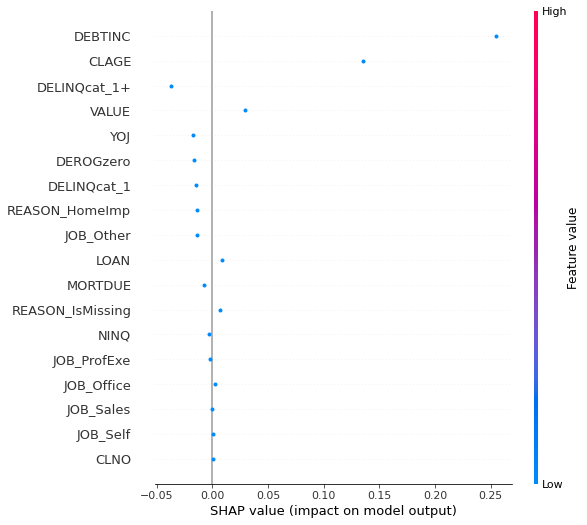

In [24]:
# Summary plot for single observation, RF model
shap.summary_plot(shap_values_rf[test_point][1].reshape(1, -1), X_test.values[test_point].reshape(1, -1), feature_names=X_var_labels)

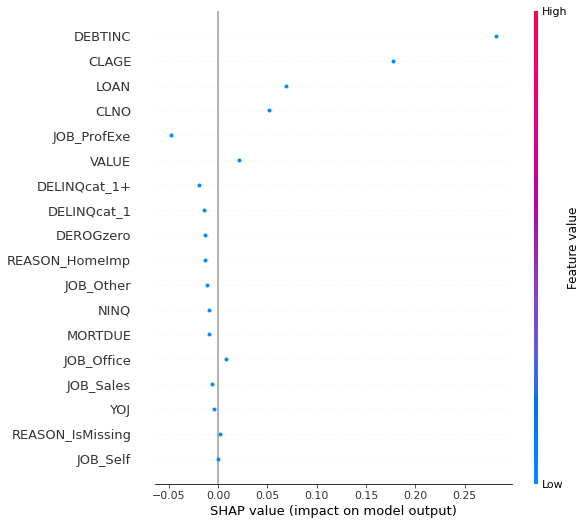

In [ ]:
# Repeat for XGB
shap.summary_plot(shap_values_xgb[test_point].reshape(1, -1), X_test.values[test_point].reshape(1, -1), feature_names=X_var_labels)

**How to read this plot:** <br>
This plot depicts:
- features  are ranked in descending order of their impact
- each feature on the y-axis
- a scale of the SHAP values on the x-axis
- the corresponding SHAP value for each feature on the graph
- each point in the plot is color-coded on a scale from blue (low) to red (high) depending on whether or not the value in our data set for this observation and feature was high or low. For a single observation, they tend to all be blue, as there is no comparison as to what is high or low. The next plots will make use of this.

The closer a point is to the horizontal line, the less impact it had on the model output.

*For example*, the feature DEBTINC has a high SHAP value, around +0.25 for the RF model and  XGB model.

**When to use this plot:** <br>
We would use this plot in the same setting as above. It gives us more insight into the SHAP values and just a different type of visualization. We can get a better idea of the actual SHAP values. This plot might be more suitable for a data analyst or someone who often deals with data visualization, while the prior one is explicitly easy to understand for people without much knowledge in this field. This plot's very useful benefit is the ranking of all variables based on their absolute SHAP values. Values that were not visible due to low impact in the first local SHAP plot are displayed here. Generally, this plot makes comparing models easier. We can see that both CLAGE and DEBTINC have similarly high impacts for both models.
On the other hand, the occupation JOB_ProfExe is deemed important for this observation based on the XGB model. In the RF model, however, it shows a SHAP value close to zero. This is an interesting insight and can help decide which model might agree more with domain knowledge. From the previous local plot we can see that the feature value for this feature and observation was 1, so `True`. It seems plausible that a person with this occupation is more likely to pay back their loan as they have a secure job. This finding also reveals a disadvantage of this plot.  We cannot read the feature values of the observation. To see how and how much each variable impacts the output, we will look at the global summary plot. 


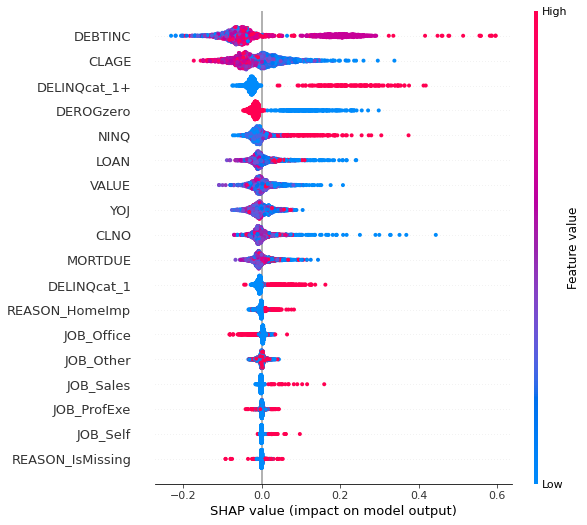

In [ ]:
# Summary plot for whole RF not single obsrvation
shap.summary_plot(shap_values_rf[1], X_test, feature_names=X_var_labels)

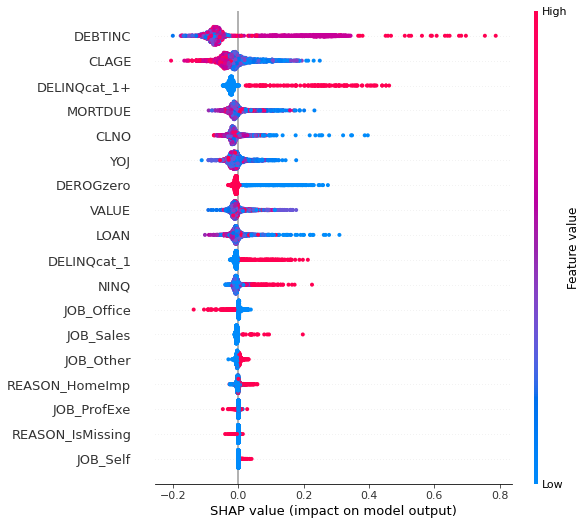

In [ ]:
# for whole XGB not single observation
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_var_labels)

**How to read this plot:** <br>
This plot is a summary of the plot above for all observations. This means that we move from a local to a global perspective. So the only difference is that instead of inspecting one observation, we can identify the SHAP values for the whole model. The features are sorted by their absolute sum of SHAP values across all samples. Also note, this is a density scatter plot, so we can identify which SHAP values were common and whether some SHAP values are more likely to correspond with a high or low feature value.

*For example*, the feature DEROGzero (`True` for observations without any major derogatory reports). It is a dummy variable, so 0 will be marked as blue (low value) and 1 as red (high value). Therefore blue dots depict observations with major derogatory reports and red dots the ones that do not have any. If DEROGzero is `True` for an observation, in general, it shows to slightly lower the risk of default according to the SHAP plots of both models. Generally, it does not impact the outcome much for both models. If it is `False`, however, we can see a great variation in positive SHAP values, between 0 and 0.35 for the RF model. 


**When to use this plot:** <br>
We would use this plot to validate the model overall. It is used to get an idea of how the model comes to its decisions and if these agree with domain knowledge. Use the example mentioned above. It makes sense that people with major derogatory reports (`DEROGzero==0`) have an increased risk of default. The SHAP values for this feature value vary. This can be explained because SHAP values are calculated depending on the different feature values for an observation and are therefore relative to these other values. It also makes sense that people without major derogatory reports (`DEROGzero==1`) might have a slight decrease in risk and the SHAP values are therefore denser. It is plausible that the feature value 0 has a higher impact on the model prediction as it carries more valuable information for the decision-making process.  DELINQcat_1+ shows the opposite relationship. It displays low, negative SHAP values for low feature values(`==0`) and high, positive values for high values(`==1`), with the feature value 1 having more impact than the feature value 0. Someone who has more than one delinquent credit line should be more likely to default. 
Furthermore, we can analyze how the models differ, for example, for the feature JOB_other. It seems that observations with a job of that category(`JOB_other==1`, red) have a slightly positive impact on prediction, while people with `JOB_other==0` show a slight decrease in risk for the XGB model. The RF model, however, does not display such a straightforward distinction.
 *Is someone with a job outside of the given categories (`_Sales, _Office, _Self, _ProfExe`) more likely to default?*   This can have two reasons. Firstly, this category gathers all other jobs. So if an observation has a feature value of 1 for this feature, they could have any other job not listed. As there are generally more low paying jobs than high paying jobs, an increase in risk if you fall into this category seems plausible.  But so does the output in the RF model, as this category also incorporates other high paying jobs, which might make it hard to find a decision-boundary for this feature. Here, we could reconfirm with someone with the necessary domain knowledge finds it more plausible. In this case, however, this feature does not impact the model outcome much and may be of less importance, as it does not carry much value, which can also lead to less precise approximations of that feature in the model.

## Conclusion

Well done! You have reached the end of this tutorial. We hope that this tutorial has shown you some insight on possible ways to visualize your model's decisions and find ways to understand their decisions, even if they are complex. For your documentation, as always, we added a table summarising the functions we made use of today. 

| Method | Possible Function | Package to be imported (if applicable) | 
| --- | --- | --- |
| feature importance| `some_model.feature_importance_` | Skitlearn |
| permutation-based feature importance | `permutation_importance()` | ` from sklearn.inspection import  permutation_importance`|
| partial dependence plot| `partial_depedence_plot()` | `from sklearn.inspection import plot_partial_dependence ` |
| **LIME**| | ` import lime`|
| LIME tabular explainer | `LimeTabularExplainer()` | ` from lime.lime_tabular import LimeTabularExplainer` |
| LIME plot |`some_LIME_explainer.show_in_notebook()`| |
| **SHAP** | | ` import shap` |
| SHAP explainer| `shap.TreeExplainer()` | |
| Calculate SHAP values| `some_SHAP_explainer.shap_values()`|  |
| SHAP force plot |`shap.force_plot()`| |
| SHAP summary plot| `shap.summary_plot()` | |
